# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp8 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [10]:
track = ['COVID19'] # define the keywords, tweets contain election

#locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [11]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [66]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [67]:
count = 100 #number of returned tweets, default and max is 100
geocode = "44.3148,-85.6024,300mi"  # defin the location, in Harrisonburg, VA
q = "COVID19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [68]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Sun Dec 12 19:00:42 +0000 2021'
'Sun Dec 12 19:00:42 +0000 2021'
'Sun Dec 12 19:00:40 +0000 2021'


Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [69]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            #pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [55]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

12192
6412


Create a text index and print the Tweets containing specific keywords. 

In [44]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [45]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pprint to display tweets

In [46]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: DerekKissach
text: @BernieSpofforth #COVID19 #coronavirus _ Next: Foetus covid19 vaccines
----
name: DerekKissach
text: @TimeOutLondon #COVID19 #coronavirus #Omicron #lockdown #COP26 _ I'm following the COP26 covid19 blueprint.
Thanks.
----
name: DerekKissach
text: @NileGardiner #COVID19 #coronavirus #Omicron _ I'm sure Margaret Thatcher would have been all over the covid19 stat… https://t.co/Fe1xZqYKWi
----
name: DerekKissach
text: @spectator @afneil @MrSteerpike #COVID19 #coronavirus #BorisJohnson #Omicron #COVID19 #coronavirus #Masks… https://t.co/FlUdQ0iK0Z
----
name: DerekKissach
text: @phyllis_fu #Covid19 #coronavirus _ So, there was no underlying cofactor to this man's covid19 death?
It's easier t… https://t.co/2SnuRKigd5
----
name: World NCD Congress 2021
text: https://t.co/KPzR6H3gVX Even during #COVID19 #NCDs remain a major killer and those with NCDs are more likely to die of #COVID19. #BeatNCDs
----
name: Kathleen 🌍💨🔥
text: Benton County Arkansas lost this deputy 

In [47]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pandas to display tweets

In [48]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,61b64177c937010755384bae,Sat Dec 04 15:36:23 +0000 2021,1467155834320916480,1467155834320916480,@BernieSpofforth #COVID19 #coronavirus _ Next:...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.467067e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,61b64166c9370107553848e9,Thu Dec 09 20:32:14 +0000 2021,1469042226105921543,1469042226105921543,@TimeOutLondon #COVID19 #coronavirus #Omicron ...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.468935e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
2,61b64160c9370107553847ee,Sat Dec 11 20:24:01 +0000 2021,1469764933772582914,1469764933772582914,@NileGardiner #COVID19 #coronavirus #Omicron _...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.469425e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
3,61b6415fc9370107553847c3,Sun Dec 12 11:19:14 +0000 2021,1469990221890609152,1469990221890609152,@spectator @afneil @MrSteerpike #COVID19 #coro...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.469952e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
4,61b64178c937010755384bbc,Sat Dec 04 13:08:31 +0000 2021,1467118620346134530,1467118620346134530,"@phyllis_fu #Covid19 #coronavirus _ So, there ...",True,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.467018e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
5,61b64170c937010755384ae0,Mon Dec 06 16:57:00 +0000 2021,1467900894645604353,1467900894645604353,https://t.co/KPzR6H3gVX Even during #COVID19 #...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://twitter.com"" rel=""nofollow"">T...",NaN,...,3,6,False,False,en,False,NaN,NaN,NaN,NaN
6,61a699e47b4313071e6d64f8,Mon Nov 29 02:58:47 +0000 2021,1465153236248285190,1465153236248285190,Benton County Arkansas lost this deputy to #CO...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,1,1,False,False,en,False,NaN,NaN,NaN,NaN
7,61b64177c937010755384ba7,Sat Dec 04 16:23:02 +0000 2021,1467167572705660932,1467167572705660932,@DiGada1 @WalesOnline #COVID19 #coronavirus #B...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.467159e+18,...,1,3,False,False,en,NaN,NaN,NaN,NaN,NaN
8,61b64176c937010755384b5d,Sun Dec 05 13:25:30 +0000 2021,1467485283419668487,1467485283419668487,@JuliaHB1 #COVID19 #coronavirus @StigAbell #Bo...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.467478e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
9,61b64178c937010755384bb7,Sat Dec 04 14:05:23 +0000 2021,1467132931097378822,1467132931097378822,@DailyMirror #COVID19 #coronavirus _ Covid19 w...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.467010e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

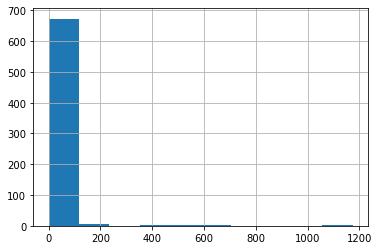

In [49]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count